In [18]:
from DarkMatter import *
from IPython.display import clear_output

# 1. Read PSF file

In [4]:
# EventDisplay
PSF_ED = readPSFFile("EventDisplay", version="v6", cut="soft")

# VEGAS
PSF_VEGAS = readPSFFile("VEGAS")

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


## - Quick check: what do they look like?

Warning in <TCanvas::Constructor>: Deleting canvas with same name: PSF


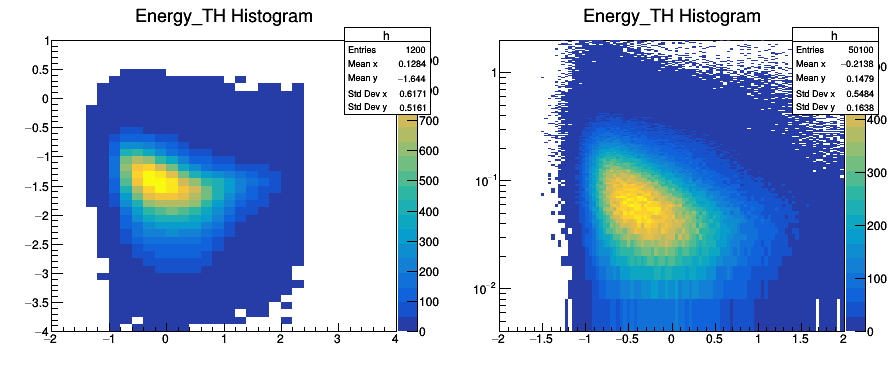

In [6]:
c = TCanvas("PSF", "PSF", 900,400)
c.Divide(2,1)
c.cd(1)
PSF_ED.Draw("colz")
c.cd(2)
PSF_VEGAS.Draw("colz")
gPad.SetLogy()
c.Draw()

# 2. Read J profile

In [7]:
# options: segue_1, bootes, draco, ursa_minor
gJProf = calcJProfile("segue_1")

## - Quick check

Text(0, 0.5, 'J profile')

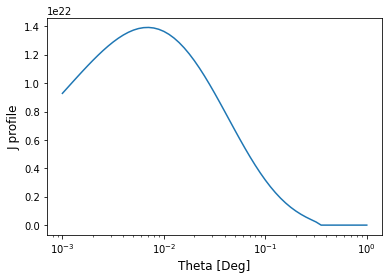

In [8]:
xJ, yJ = getArray(gJProf)
plt.plot(xJ, yJ)
plt.xscale("log")
plt.xlabel("Theta [Deg]", fontsize=12)
plt.ylabel("J profile", fontsize=12)

# 3. Get PSF (dP/d$\Omega$) in a specific energy (e.g., 10 TeV)

In [9]:
# EventDisplay
gPSF1D_ED = getPSF1D(PSF_ED, 10000, package="EventDisplay")

# VEGAS
gPSF1D_VEGAS = getPSF1D(PSF_VEGAS, 10000, package="VEGAS")

## - If you want to check whether PSF is well normailzed, do this (this takes time).

In [10]:
%%timeit -r 1 -n 1
gPSF1D_ED = getPSF1D(PSF_ED, 100000, package="EventDisplay", check=True)

Getting PSF with energy of:  100000 GeV
PSF Integral from +/- 2 deg:  1.0003230150203093
14.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## - Quick check

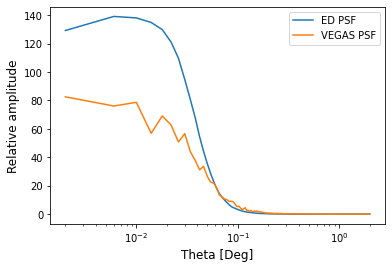

In [11]:
xPE, yPE = getArray(gPSF1D_ED)
xPV, yPV = getArray(gPSF1D_VEGAS)

plt.plot(xPE, yPE, label="ED PSF")
plt.plot(xPV, yPV, label="VEGAS PSF")
plt.xscale("log")

plt.xlabel("Theta [Deg]", fontsize=12)
plt.ylabel("Relative amplitude", fontsize=12)

plt.legend()

## - Quick check: Compare relative strength at a certain theta

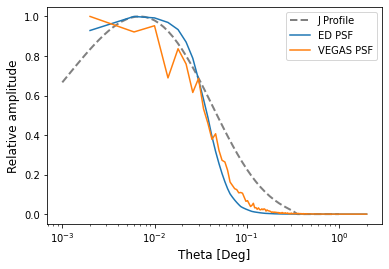

In [12]:
xJ, yJ = getArray(gJProf)
xPE, yPE = getArray(gPSF1D_ED)
xPV, yPV = getArray(gPSF1D_VEGAS)

plt.plot(xJ, yJ/max(yJ), lw = 2, ls= "--", color="gray", label = "J Profile")
plt.plot(xPE, yPE/max(yPE), label="ED PSF")
plt.plot(xPV, yPV/max(yPV), label="VEGAS PSF")
plt.xscale("log")
plt.xlabel("Theta [Deg]", fontsize=12)
plt.ylabel("Relative amplitude", fontsize=12)
plt.legend()

# 4. Convolution between the J profile and PSF

## - Calculate a 2D radial J profile for a given energy and its integration.

- Note that the original method takes long time, so that I modified the original one. If you want to use the original method, use "calcConvJProf2D_original". 
    - The difference of the convolved J values from two methods is less than 1%. The difference originates from the edge of theta (theta ~ 1).
    - The original method takes about 10-15 min per each energy band, whereas a new method takes < 15 s.

In [13]:
hJProf2D, J, J_ncov = calcConvJProf2D(gJProf, gPSF1D_ED)

100% Done


Warning in <TROOT::Append>: Replacing existing TH1: hProfConv (Potential memory leak).


## - Get a 1D radial J profile for a given energy

In [14]:
gRadJProf, J = getRadialConvJProf(hJProf2D)

Warning in <TROOT::Append>: Replacing existing TH1: hRadJProf (Potential memory leak).


## - Quick check 1: What do they look like?

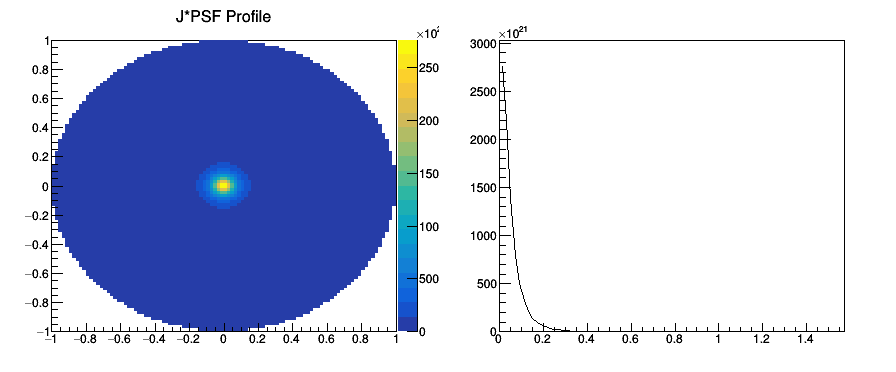

In [15]:
c = TCanvas("J profile", "J profile", 900,400)
c.Divide(2,1)
c.cd(1)
hJProf2D.Draw("colz")
c.cd(2)
gRadJProf.Draw()
c.Draw()

## - Quick check 2: Consistency between 1D and 2D profiles.

In [16]:
Jfrom2D, etc = calcConvJ(hJProf2D, verbose=True)
Jfrom1D = calcConvJ_rad(gRadJProf, verbose=True)

print("J factor ratio: {:.2f}%".format(abs(Jfrom2D-Jfrom1D)/Jfrom2D*100))

J factor (w/ convolution):  1.3908157402136302e+19
J factor (w/ convolution):  1.3700204090338441e+19
J factor ratio: 1.50%


# 5. Preparation for moving to the next step

In [17]:
OutFile = "tutorial.root"
dwarf = "segue_1"

In [ ]:
OutFile = TFile(OutFile,"RECREATE");

convJvE = TGraph()

energies = eknots()

PSF_ED = readPSFFile("EventDisplay", version="v6", cut="moderate")
gJProf = calcJProfile(dwarf)

for en, i in zip(energies, range(len(energies))):
    print("           ({:.3f} TeV)".format(en/1000.), end="\r")
    gPSF_ED = getPSF1D(PSF_ED, en, package="EventDisplay")
    hJProf2D, J, etc = calcConvJProf2D(gJProf, gPSF_ED)
    gRadJProf, etc = getRadialConvJProf(hJProf2D)
    
    convJvE.SetPoint(i, en, J)
    OutFile.cd()
    
    hJProf2D.Write("hE_{}".format(int(en)))
    gPSF_ED.Write("gPSF_{}".format(int(en)))
    gRadJProf.Write("gRadJProf_{}".format(int(en)))

convJvE.SetTitle(r"Convolved J profile; Energy [GeV]; J ($\theta$ < 0.17)")
convJvE.Write("gConvJvE")
OutFile.Close()
clear_output()

## - Create the 2D J profile in energy and theta.

In [19]:
calcConvJ2D("tutorial.root")

## - Quick check: What do they look like?

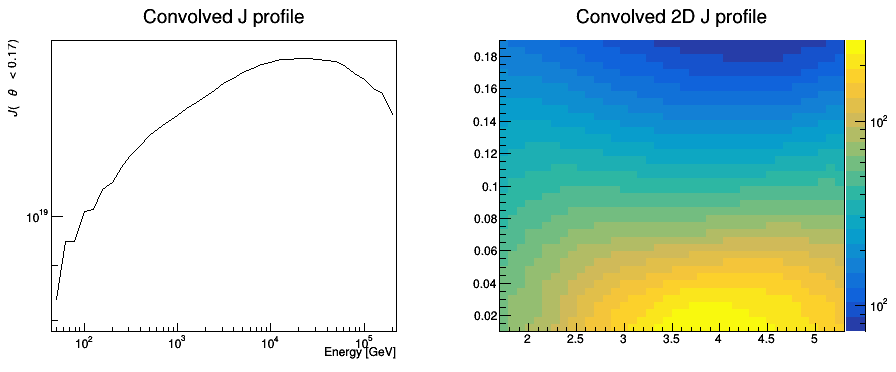

In [20]:
File = TFile("tutorial.root")
c = TCanvas("PSF", "PSF", 900,400)
c.Divide(2,1)
c.cd(1)
File.gConvJvE.Draw()
File.gConvJvE.SetTitle(r"Convolved J profile;Energy [GeV];J ($\theta$ < 0.17)")
gPad.SetLogx()
gPad.SetLogy()
c.cd(2)
File.gConvJvEtheta.Draw("colz")
File.gConvJvEtheta.SetTitle("Convolved 2D J profile")
gPad.SetLogz()
c.Draw()

## - Quick check: Are they consistent?

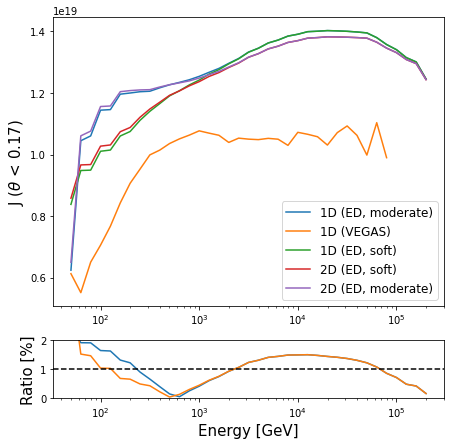

In [23]:
File_v = TFile("./DM-Aspen/MaximumLikelihoodDM/SimplifiedVersion/output.root")
File_s = TFile("./tutorial.root")
File_m = TFile("./tutorial_moderate.root")

J1D_xm, J1D_ym = getArray(File_m.gConvJvE)
J1D_xv, J1D_yv = getArray(File_v.gConvJvE)
J1D_xs, J1D_ys = getArray(File_s.gConvJvE)

raw_J2D = File_s.gConvJvEtheta
J2D_ys = calcConvJ_rad_multi(raw_J2D)
raw_J2D = File_m.gConvJvEtheta
J2D_ym = calcConvJ_rad_multi(raw_J2D)

f, ax = plt.subplots(2,1, figsize=(7, 7), gridspec_kw={'height_ratios':[5,1]})
ax[0].plot(J1D_xm, J1D_ym, label="1D (ED, moderate)")
ax[0].plot(J1D_xv, J1D_yv, label="1D (VEGAS)")
ax[0].plot(J1D_xs, J1D_ys, label="1D (ED, soft)")

ax[0].plot(J1D_xs, J2D_ys, label="2D (ED, soft)")
ax[0].plot(J1D_xs, J2D_ym, label="2D (ED, moderate)")

ax[0].set_xscale("log")
ax[0].set_ylabel(r"J ($\theta$ < 0.17)", fontsize=15)
ax[0].legend(fontsize=12, loc=4)
ax[1].plot(J1D_xs, abs(J1D_ys-J2D_ys)/J1D_ys*100, label="2D/1D (soft)")
ax[1].plot(J1D_xs, abs(J1D_ym-J2D_ym)/J1D_ym*100, label="2D/1D (moderate)")
ax[1].set_xscale("log")
ax[1].set_xlabel("Energy [GeV]", fontsize=15)
ax[1].set_ylabel("Ratio [%]", fontsize=15)
ax[1].set_ylim(0, 2)
ax[1].axhline(1, color="k", ls="--")
